# Imports

In [54]:
import os
import librosa
import librosa.display

import numpy as np
import pandas as pd
import IPython as ipd
import plotly.express as px
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Functions

In [ ]:
def analyze_timbre_to_dataframe_all_frames(audio_path: str, n_mfcc: int = 13):
    """
    Gets features to analyze vocal timbre per frame
    """
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)

    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    # print(spectral_centroid)

    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)[0]
    # print(spectral_rolloff)

    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)[0]
    # print(zero_crossing_rate)

    # transpose to get frames as rows
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T

    chroma = librosa.feature.chroma_stft(y=y, sr=sr).T

    spectral_flux = librosa.onset.onset_strength(y=y, sr=sr)

    tempo, _ = librosa.beat.beat_track(onset_envelope=spectral_flux, sr=sr)

    data = {
        "frame": np.arange(len(spectral_centroid)),
        "spectral_centroid": spectral_centroid,
        "spectral_rolloff": spectral_rolloff,
        "zero_crossing_rate": zero_crossing_rate,
        "tempo": [tempo] * len(spectral_centroid)
    }

    # add MFCCs and Chroma to dictionary
    for i in range(n_mfcc):
        data[f"mfcc_{i+1}"] = mfcc[:, i]

    for i in range(chroma.shape[1]):
        data[f"chroma_{i+1}"] = chroma[:, i]

    df = pd.DataFrame(data)

    df["spectral_flux"] = spectral_flux[:len(df)]

    return df



In [ ]:
def analyze_timbre_to_dataframe_w_avgs(audio_path: str, n_mfcc: int = 13):
    """
    Gets features to analyze vocal timbre by averaging features across every frame
    """
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)

    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    # print(spectral_centroid)

    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)[0]
    # print(spectral_rolloff)

    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)[0]
    # print(zero_crossing_rate)

    # transpose to get frames as rows
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T

    chroma = librosa.feature.chroma_stft(y=y, sr=sr).T

    spectral_flux = librosa.onset.onset_strength(y=y, sr=sr)

    # tempo, _ = librosa.beat.beat_track(onset_envelope=spectral_flux, sr=sr)

    features = {
        # "artist": [audio_path],
        "mfcc": [np.mean(mfcc)],
        "spectral_centroid": [np.mean(spectral_centroid)],
        "spectral_flux": [np.mean(spectral_flux)],
        "spectral_rolloff": [np.mean(spectral_rolloff)],
        "zero_crossing_rate": [np.mean(zero_crossing_rate)],
        "chroma": [np.mean(chroma)]
    }

    # flatten the dictionary into a single vector of features
    feature_vector = np.concatenate(list(features.values()))

    return feature_vector

# Playground

In [106]:
DATA_DIR = Path("data")

file_paths = []
for file in os.listdir(DATA_DIR):
    if file == ".DS_Store":
        continue

    print(file)
    file_paths.append(file)

Beyonce2_foreground_vocals.wav
Adele2_foreground_vocals.wav
Beyonce_foreground_vocals.wav
SZA2_foreground_vocals.wav
Adele_foreground_vocals.wav
Whitney_foreground_vocals.wav
SZA_foreground_vocals.wav
Adele3_foreground_vocals.wav
Beyonce3_foreground_vocals.wav
SZA3_foreground_vocals.wav


In [ ]:
all_features = []

for filename in file_paths:
    feature_vector = analyze_timbre_to_dataframe_w_avgs(audio_path= DATA_DIR / filename)
    all_features.append(feature_vector)

# convert features to dataframe
df = pd.DataFrame(all_features, columns=["mfcc", "spectral_centroid", "spectral_flux", "spectral_rolloff", "zero_crossing_rate", "chroma"])

In [108]:
df

,mfcc,spectral_centroid,spectral_flux,spectral_rolloff,zero_crossing_rate,chroma
0,-34.312157,2653.938743,1.926958,4675.296142,0.176231,0.220311
1,-30.286701,2910.580579,1.250553,5102.326068,0.195042,0.232074
2,-30.743858,2668.087934,1.826119,4572.908026,0.179440,0.215246
3,-29.948076,2321.220770,1.653840,4065.307617,0.144988,0.236145
4,-32.762814,2786.458281,1.566974,4890.332206,0.187471,0.245257
5,-35.025097,3100.703520,1.460531,5579.677736,0.217537,0.229565
6,-34.506031,3265.172909,2.070094,5447.723202,0.214386,0.246258
7,-33.216553,3728.627196,1.953180,6641.234590,0.254670,0.224063
8,-35.997620,3003.008862,1.526667,5275.528000,0.201072,0.230362
9,-28.508251,2459.797850,1.866456,4309.297239,0.152411,0.227733


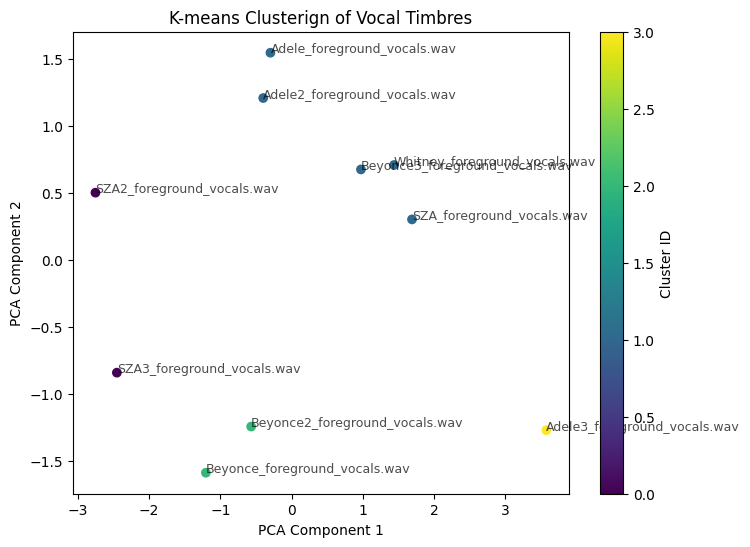

In [109]:
# standardize features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# k means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df["cluster"] = kmeans.fit_predict(df_scaled)

# Reduce dimensions with PCA for visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# plot
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df["cluster"], cmap="viridis", marker="o")
plt.title("K-means Clusterign of Vocal Timbres")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

for i, filename in enumerate(file_paths):
    plt.annotate(filename, (df_pca[i, 0], df_pca[i, 1]), fontsize=9, alpha=0.7)

plt.colorbar(label="Cluster ID")

plt.show()

In [113]:
df.loc[:, "arist"] = file_paths

In [114]:
df

,mfcc,spectral_centroid,spectral_flux,spectral_rolloff,zero_crossing_rate,chroma,cluster,arist
0,-34.312157,2653.938743,1.926958,4675.296142,0.176231,0.220311,2,Beyonce2_foreground_vocals.wav
1,-30.286701,2910.580579,1.250553,5102.326068,0.195042,0.232074,1,Adele2_foreground_vocals.wav
2,-30.743858,2668.087934,1.826119,4572.908026,0.179440,0.215246,2,Beyonce_foreground_vocals.wav
3,-29.948076,2321.220770,1.653840,4065.307617,0.144988,0.236145,0,SZA2_foreground_vocals.wav
4,-32.762814,2786.458281,1.566974,4890.332206,0.187471,0.245257,1,Adele_foreground_vocals.wav
5,-35.025097,3100.703520,1.460531,5579.677736,0.217537,0.229565,1,Whitney_foreground_vocals.wav
6,-34.506031,3265.172909,2.070094,5447.723202,0.214386,0.246258,1,SZA_foreground_vocals.wav
7,-33.216553,3728.627196,1.953180,6641.234590,0.254670,0.224063,3,Adele3_foreground_vocals.wav
8,-35.997620,3003.008862,1.526667,5275.528000,0.201072,0.230362,1,Beyonce3_foreground_vocals.wav
9,-28.508251,2459.797850,1.866456,4309.297239,0.152411,0.227733,0,SZA3_foreground_vocals.wav


# TODO:
- Try using different source separation method for better vocal quality (currently using forground vocals produced from the yt_download_source_separation project)
- Implement different methods to have n_clusters chosen automatically (elbow, silhouette method, etc.)
- Increase number of artists in dataset